In [1]:
import pandas as pd
import sklearn as skl
import numpy as np

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Make sure to add NUS_datathon_team_10_files to MyDrive as shortcut
# merged_path = "/content/drive/MyDrive/NUS_datathon_team_10_files/merged_data_ethnicity_cleaned.csv"
merged_path = "/content/drive/MyDrive/NUS_datathon_team_10_files/merged_data_with_tbi_cnsinfect.csv"
df_merged = pd.read_csv(merged_path)

Mounted at /content/drive


### EDA

In [2]:
df_merged.head()

,subject_id,median_temp,temp_gap,hadm_id,stay_id,gender,dod,admittime,dischtime,los_hospital,...,cardiac_arrest,sepsis,aki,icu_intime_48,proportion_within_range,proportion_above,proportion_below,ethnicity,tbi,cns_infect
0,10000032,37.06,0.44,29079034,39553978,F,2180-09-09,2180-07-23 12:35:00.000,2180-07-25 17:55:00.000,2.222222,...,0,0,0,2180-07-25 14:00:00,1.000000,0.000000,0.000000,WHITE,0,0
1,10000980,36.67,0.56,26913865,39765666,F,2193-08-26,2189-06-27 07:38:00.000,2189-07-03 03:00:00.000,5.806944,...,0,0,0,2189-06-29 08:42:00,1.000000,0.000000,0.000000,BLACK,0,0
2,10001217,37.28,1.50,24597018,37067082,F,NaN,2157-11-18 22:56:00.000,2157-11-25 18:00:00.000,6.794444,...,0,0,0,2157-11-22 19:18:02,0.888889,0.111111,0.000000,WHITE,0,0
3,10001725,36.53,0.50,25563031,31205490,F,NaN,2110-04-11 15:08:00.000,2110-04-14 15:00:00.000,2.994444,...,0,0,0,2110-04-13 15:52:22,1.000000,0.000000,0.000000,WHITE,0,0
4,10001884,36.70,2.20,26184834,37510196,F,2131-01-20,2131-01-07 20:39:00.000,2131-01-20 05:15:00.000,12.358333,...,1,1,0,2131-01-13 04:20:05,0.914286,0.000000,0.085714,BLACK,0,0


In [3]:
# extracted_cols = ["subject_id", "ethnicity"]
# df_ethnicity_extracted = df_merged_ethnicity[extracted_cols]
# df_merged = pd.merge(df_merged, df_ethnicity_extracted, how="left", on="subject_id")
# df_merged = df_merged.drop(['ethnicity_x', "ethnicity_y"], axis=1)
# df_merged.to_csv('/content/drive/MyDrive/NUS_datathon_team_10_files/merged_data_cleaned.csv', index=False)
# df_merged.head()

In [4]:
confounders = ["admission_age", "gender", "apsiii", "charlson_score", "median_temp", "temp_gap"]
for i in confounders:
  print(df_merged[i].isnull().values.any())
subgroups = ["stroke", "sepsis", "cardiac_arrest", "admission_age", "ethnicity"] # missing TBI
for i in subgroups:
  print(df_merged[i].isnull().values.any())

False
False
False
False
False
False
False
False
False
False
False


### Cleaning Data

In [5]:
# Add new column for ethnicity
df_merged["is_black"] = df_merged['ethnicity'] == "BLACK"
df_merged["is_black"] = df_merged["is_black"].astype(int)

In [6]:
# Change gender to 1 or 0
df_merged["gender"] = df_merged.gender.astype("category").cat.codes

In [7]:
df_merged["older_75"] = df_merged['admission_age'] >= 75
df_merged["older_75"] = df_merged["older_75"].astype(int)

### GAM

In [10]:
!pip install pygam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.2 MB/s 


In [11]:
pd.set_option('display.max_columns', None)
df_merged.head()

,subject_id,median_temp,temp_gap,hadm_id,stay_id,gender,dod,admittime,dischtime,los_hospital,admission_age,race,hospital_expire_flag,hospstay_seq,first_hosp_stay,icu_intime,icu_outtime,los_icu,icustay_seq,first_icu_stay,icu_death,weight_admit,height,bmi,admission_type,first_careunit,last_careunit,charlson_score,apsiii,max_sofa,min_gcs,vasopressor,dialysis,invasive_vent,non_invasive_vent,malignant_cancer,chf,copd,ckd,atrial_fibrillation,cld,diabetes,ihd,stroke,hypertension,cardiac_arrest,sepsis,aki,icu_intime_48,proportion_within_range,proportion_above,proportion_below,ethnicity,tbi,cns_infect,is_black,older_75
0,10000032,37.06,0.44,29079034,39553978,0,2180-09-09,2180-07-23 12:35:00.000,2180-07-25 17:55:00.000,2.222222,52.559969,WHITE,0,1,True,2180-07-23 14:00:00,2180-07-23 23:50:47.000,0.41,1,True,0,39.4,152.0,17.0,EW EMER.,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),4,54,2.0,14.0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,2180-07-25 14:00:00,1.000000,0.000000,0.000000,WHITE,0,0,0,0
1,10000980,36.67,0.56,26913865,39765666,0,2193-08-26,2189-06-27 07:38:00.000,2189-07-03 03:00:00.000,5.806944,76.486231,BLACK/AFRICAN AMERICAN,0,1,True,2189-06-27 08:42:00,2189-06-27 20:38:27.000,0.50,1,True,0,76.2,NaN,NaN,EW EMER.,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),9,32,0.0,15.0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,2189-06-29 08:42:00,1.000000,0.000000,0.000000,BLACK,0,0,1,1
2,10001217,37.28,1.50,24597018,37067082,0,NaN,2157-11-18 22:56:00.000,2157-11-25 18:00:00.000,6.794444,55.881486,WHITE,0,1,True,2157-11-20 19:18:02,2157-11-21 22:08:00.000,1.12,1,True,0,71.2,NaN,NaN,EW EMER.,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2,22,0.0,15.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2157-11-22 19:18:02,0.888889,0.111111,0.000000,WHITE,0,0,0,0
3,10001725,36.53,0.50,25563031,31205490,0,NaN,2110-04-11 15:08:00.000,2110-04-14 15:00:00.000,2.994444,46.275517,WHITE,0,1,True,2110-04-11 15:52:22,2110-04-12 23:59:56.000,1.34,1,True,0,72.2,157.0,29.0,EW EMER.,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2,32,1.0,15.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2110-04-13 15:52:22,1.000000,0.000000,0.000000,WHITE,0,0,0,0
4,10001884,36.70,2.20,26184834,37510196,0,2131-01-20,2131-01-07 20:39:00.000,2131-01-20 05:15:00.000,12.358333,77.018296,BLACK/AFRICAN AMERICAN,1,1,True,2131-01-11 04:20:05,2131-01-20 08:27:30.000,9.17,1,True,1,65.0,157.0,26.0,OBSERVATION ADMIT,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),6,51,4.0,15.0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,1,0,2131-01-13 04:20:05,0.914286,0.000000,0.085714,BLACK,0,0,1,1


In [12]:
def get_y_train(df):
  return df["hospital_expire_flag"].to_frame()

def filter_feature(ft):
  return df_merged.loc[df_merged[ft] == 1]
# y_train=df_merged["hospital_expire_flag"].to_frame()

In [40]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams['font.size'] = '18'
def plot_graph(g, title):
  f = plt.figure()

  titles = ["median_temp"]
  XX = g.generate_X_grid(term=0)
  plt.plot(XX[:, 0], g.partial_dependence(term=0, X=XX))
  plt.plot(XX[:, 0], g.partial_dependence(term=0, X=XX, width=.95)[1], c='r', ls='--')
  plt.title(title, fontsize = 20)
  f.set_figwidth(10)
  f.set_figheight(6)
  plt.xlabel('Temperature', fontsize=18)
  plt.legend(["Fitted line", "95% CI"], loc ="upper right")
  plt.savefig(f'/content/drive/MyDrive/NUS_datathon_team_10_files/Graphs/MIMIC {title}.png')


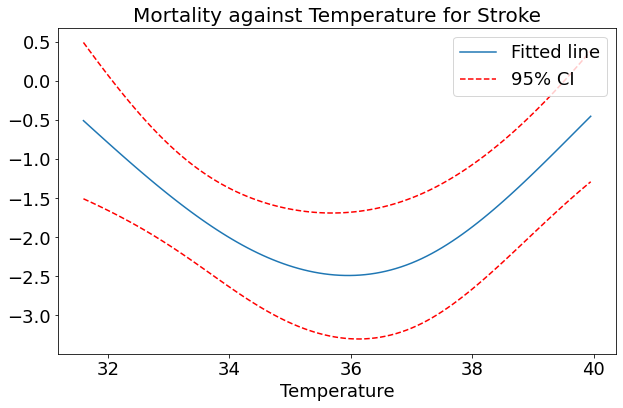

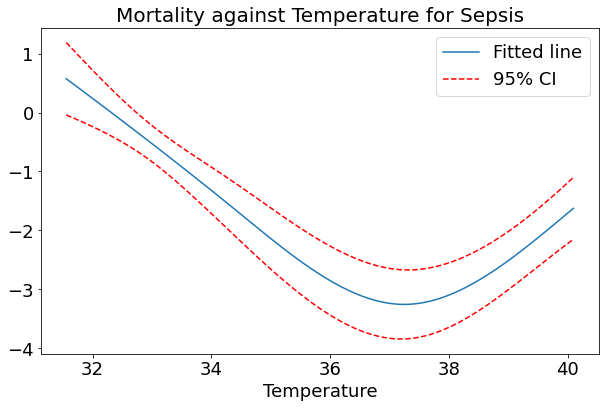

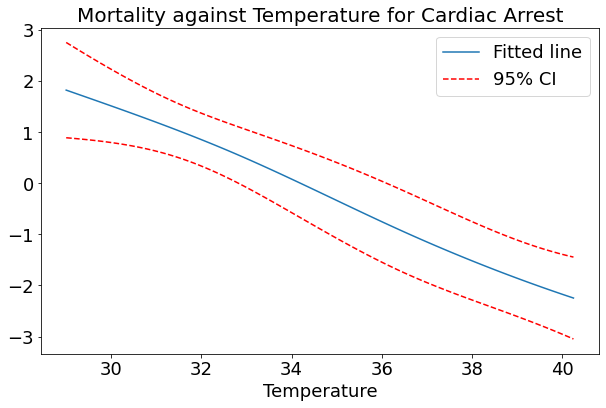

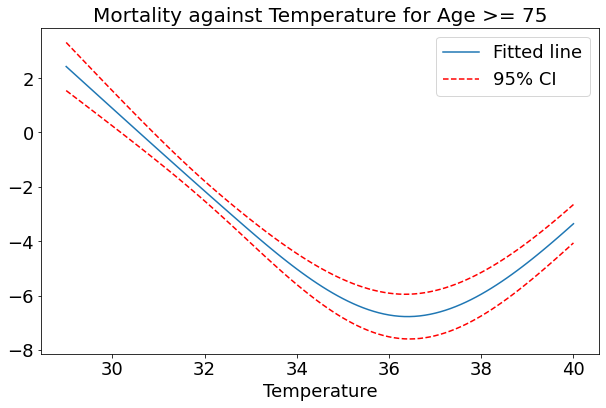

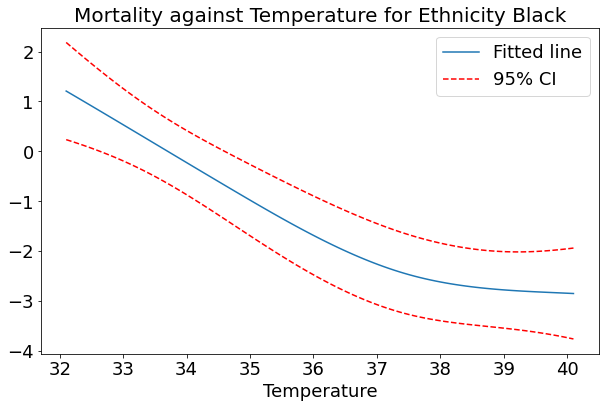

In [41]:
from pygam import LogisticGAM, s, l, f
subgroups = ["stroke", "sepsis", "cardiac_arrest", "older_75", "is_black"] # missing TBI, CNS
# cardiac arrest and is_black graph works well when n_splines = 8/9
titles = ["Stroke", "Sepsis", "Cardiac Arrest", "Age >= 75", "Ethnicity Black"]
for index, i in enumerate(subgroups):
  df_subgroup = filter_feature(i)
  y_train = get_y_train(df_subgroup)
  X = df_subgroup[["median_temp","temp_gap", "admission_age","gender","charlson_score","apsiii"]]
  gam = LogisticGAM(terms=(s(0, n_splines = 6) + s(1, n_splines = 6) + l(2) + f(3) + l(4)) + l(5)).fit(X, y_train)
  plot_graph(gam, f"Mortality against Temperature for {titles[index]}")

